# Problem Description

### Predict employee attrition

Employee Attrition is a huge problem across industries and generally costs the company a lot for
hiring, retraining, productivity and work loss for each employee who leaves. Price and Waters, a
boutique data science consulting firm, is looking to build a Machine Learning model to predict
whether an Employee might quit. Using this model, they might plan human intervention to alleviate
the issues faced by the employee. The firm is also interested in specific features that are highly
indicative of attrition.

The company in a pilot program, recorded employee data. The company collected employee
performance data for some of the months randomly for each employee to understand it in the context
of attrition. The company wants you to predict whether an employee would quit in the near future,
given the data and to discover features indicative of attrition.

‘Left_Company’ is the target variable and you would have to predict either ‘1’ (Left), ‘0’ (Retained) for
each unique employee id in the test dataset.

### Attribute details:

● Left_Company (Target) : Whether the employee left the company or not (1 - Yes, 0 - No)

● EmployeeID : A unique identification key for every individual employee

● TotalWorkingHours : The total working hours logged for the employee at the location

● Billable_Hours : The number of hours that are used to charge the Client

● Hours_off_Duty : Number of hours the employee took off

● Touring_Hours : Number of hours the employee spent working at an offsite location

● NoOfProjects : Number of Projects the employee is assigned to

● ActualTimeSpent : Actual time the employee spent working according to the timesheets

● Specific data regarding Employees for both Train and Test data

● EmployeeID : A unique identification key for every individual employee

● Job_History : A feature containing the previous companies where the employee was employed

● Joining_Date : The date on which the employee Joined the organisation

● Designation : The role of the employee in the company, with the following levels: EVP, Junior, MD,
  Senior, VP

● Sex : The gender of the employee
    

In [64]:
import os

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import warnings
warnings.filterwarnings('ignore')

## Reading data

In [2]:
train_attrition = pd.read_csv("train_attrition.csv",sep=',', header=0, na_values='unknown')
train_work = pd.read_csv("train_work.csv",sep=',', header=0, na_values='unknown')
test_attrition = pd.read_csv("test_attrition.csv",sep=',', header=0, na_values='unknown')
test_work = pd.read_csv("test_work.csv",sep=',', header=0, na_values='unknown')
employee_data = pd.read_csv("employee_data.csv",sep=',', header=0, na_values='unknown')

In [3]:
print(train_attrition.shape)
print(train_work.shape)
print(test_attrition.shape)
print(test_work.shape)
print(employee_data.shape)

(245, 2)
(3983, 7)
(51, 2)
(874, 7)
(296, 5)


## Grouping values by EmployeeID


### For train

In [4]:
train_work_group = train_work.groupby('EmployeeID').sum().reset_index()

In [5]:
print(train_work_group.shape)

(245, 7)


In [6]:
train_work_group.head()

,EmployeeID,TotalWorkingHours,Billable_Hours,Hours_off_Duty,Touring_Hours,NoOfProjects,ActualTimeSpent
0,emp-1,3424.0,2462.0,408.0,2462.0,42,2849
1,emp-10,2006.0,1274.0,328.0,691.0,13,616
2,emp-100,3607.0,3275.0,224.0,3235.0,23,3388
3,emp-101,4109.5,2759.5,192.0,0.0,18,1953
4,emp-102,3790.0,2720.5,344.0,1861.0,20,2254


### For test

In [7]:
test_work_group = test_work.groupby('EmployeeID').sum().reset_index()

In [8]:
print(test_work_group.shape)

(51, 7)


In [9]:
test_work_group.head()

,EmployeeID,TotalWorkingHours,Billable_Hours,Hours_off_Duty,Touring_Hours,NoOfProjects,ActualTimeSpent
0,emp-106,3309.5,2352.0,298.0,2.0,18,1736
1,emp-112,3178.5,2610.0,292.0,325.0,21,1708
2,emp-114,3072.5,1618.7,264.0,1104.0,25,882
3,emp-118,2400.0,2008.0,146.0,728.0,18,1526
4,emp-12,4491.0,2653.0,601.0,799.0,31,1883


## Merging Data

### For Train

In [10]:
train_merge_work = pd.merge(train_attrition, train_work_group, on = 'EmployeeID')

In [11]:
train_merge_empdata = pd.merge(train_merge_work, employee_data, on = 'EmployeeID')

In [12]:
train_merge_empdata.shape

(245, 12)

In [13]:
train_merge_empdata.head()

,EmployeeID,Left_Company,TotalWorkingHours,Billable_Hours,Hours_off_Duty,Touring_Hours,NoOfProjects,ActualTimeSpent,Job_History,Joining_Date,Designation,Sex
0,emp-1,0.0,3424.0,2462.0,408.0,2462.0,42,2849,"Worked at Company - 639 , Company - 212 , Comp...",2011_01,MD,1
1,emp-10,1.0,2006.0,1274.0,328.0,691.0,13,616,"Worked at Company - 816 , Company - 724 , Comp...",2006_02,VP,0
2,emp-100,0.0,3607.0,3275.0,224.0,3235.0,23,3388,"Worked at Company - 562 , Company - 319",2011_12,Senior,1
3,emp-101,0.0,4109.5,2759.5,192.0,0.0,18,1953,"Worked at Company - 212 , Company - 668 , Comp...",2012_01,Senior,1
4,emp-102,0.0,3790.0,2720.5,344.0,1861.0,20,2254,Worked at Company - 234,2011_12,Senior,1


### For Test

In [14]:
test_merge_work = pd.merge(test_attrition, test_work_group, on = 'EmployeeID')

In [15]:
test_merge_empdata = pd.merge(test_merge_work, employee_data, on = 'EmployeeID')

In [16]:
test_merge_empdata.shape

(51, 12)

In [17]:
test_merge_empdata.head()

,EmployeeID,Left_Company,TotalWorkingHours,Billable_Hours,Hours_off_Duty,Touring_Hours,NoOfProjects,ActualTimeSpent,Job_History,Joining_Date,Designation,Sex
0,emp-106,NaN,3309.5,2352.0,298.0,2.0,18,1736,"Worked at Company - 510 , Company - 658 , Comp...",2012_01,Senior,0
1,emp-112,NaN,3178.5,2610.0,292.0,325.0,21,1708,"Worked at Company - 42 , Company - 432 , Compa...",2012_02,VP,1
2,emp-114,NaN,3072.5,1618.7,264.0,1104.0,25,882,"Worked at Company - 99 , Company - 88 , Compan...",2012_02,EVP,1
3,emp-118,NaN,2400.0,2008.0,146.0,728.0,18,1526,"Worked at Company - 554 , Company - 304",2012_04,EVP,1
4,emp-12,NaN,4491.0,2653.0,601.0,799.0,31,1883,"Worked at Company - 548 , Company - 405",2006_09,VP,1


#### Droping target column "Left_company" in test data due to null values

In [18]:
test_merge_empdata.drop("Left_Company",axis = 1,inplace = True)
test_merge_empdata.head()


,EmployeeID,TotalWorkingHours,Billable_Hours,Hours_off_Duty,Touring_Hours,NoOfProjects,ActualTimeSpent,Job_History,Joining_Date,Designation,Sex
0,emp-106,3309.5,2352.0,298.0,2.0,18,1736,"Worked at Company - 510 , Company - 658 , Comp...",2012_01,Senior,0
1,emp-112,3178.5,2610.0,292.0,325.0,21,1708,"Worked at Company - 42 , Company - 432 , Compa...",2012_02,VP,1
2,emp-114,3072.5,1618.7,264.0,1104.0,25,882,"Worked at Company - 99 , Company - 88 , Compan...",2012_02,EVP,1
3,emp-118,2400.0,2008.0,146.0,728.0,18,1526,"Worked at Company - 554 , Company - 304",2012_04,EVP,1
4,emp-12,4491.0,2653.0,601.0,799.0,31,1883,"Worked at Company - 548 , Company - 405",2006_09,VP,1


In [19]:
test_merge_empdata.shape

(51, 11)

## Feature engineering for 'Joining data' & 'Job History'

### converting string in to category

In [20]:
train_merge_empdata['Joining_Date'] = train_merge_empdata['Joining_Date'].str.split('_').str[0]


In [21]:
train_merge_empdata['Job_History'] = train_merge_empdata['Job_History'].str.split(',').str.len()


In [22]:
train_merge_empdata.head(2)

,EmployeeID,Left_Company,TotalWorkingHours,Billable_Hours,Hours_off_Duty,Touring_Hours,NoOfProjects,ActualTimeSpent,Job_History,Joining_Date,Designation,Sex
0,emp-1,0.0,3424.0,2462.0,408.0,2462.0,42,2849,3,2011,MD,1
1,emp-10,1.0,2006.0,1274.0,328.0,691.0,13,616,4,2006,VP,0


## Understanding the data

### For Train

In [23]:
train_merge_empdata.describe()

,Left_Company,TotalWorkingHours,Billable_Hours,Hours_off_Duty,Touring_Hours,NoOfProjects,ActualTimeSpent,Job_History,Sex
count,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000,245.000000
mean,0.110204,3061.481224,2097.439592,261.702041,1063.230612,20.510204,1534.514286,2.771429,0.881633
std,0.313785,1377.138318,1149.058255,146.644543,1077.686591,12.461288,1078.828104,1.433213,0.323704
min,0.000000,90.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,1986.299999,1090.000000,145.500000,80.500000,11.000000,686.000000,2.000000,1.000000
50%,0.000000,3180.000000,2145.500000,256.000000,720.000000,20.000000,1400.000000,3.000000,1.000000
75%,0.000000,4228.000000,3158.000000,388.000000,1695.500000,28.000000,2324.000000,4.000000,1.000000
max,1.000000,5406.900000,4279.500000,616.500000,3857.000000,78.000000,4113.000000,7.000000,1.000000


In [24]:
train_merge_empdata.shape

(245, 12)

### For Test

In [25]:
test_merge_empdata.describe()

,TotalWorkingHours,Billable_Hours,Hours_off_Duty,Touring_Hours,NoOfProjects,ActualTimeSpent,Sex
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,3207.686275,2333.184314,303.592157,1096.033333,23.392157,1687.411765,0.843137
std,1490.545258,1236.255732,176.473979,1079.398730,15.297161,1111.595073,0.367290
min,601.000000,342.000000,16.000000,0.000000,4.000000,112.000000,0.000000
25%,1672.000000,1207.000000,145.000000,67.000000,10.000000,717.500000,1.000000
50%,4056.000000,2631.500000,352.000000,854.000000,24.000000,1736.000000,1.000000
75%,4422.000000,3520.350000,403.500000,1870.500000,29.500000,2649.500000,1.000000
max,5294.000000,4285.500000,859.000000,3533.500000,83.000000,3850.000000,1.000000


In [26]:
test_merge_empdata.shape

(51, 11)

## Checking data types

### For Train

In [27]:
train_merge_empdata.dtypes

EmployeeID            object
Left_Company         float64
TotalWorkingHours    float64
Billable_Hours       float64
Hours_off_Duty       float64
Touring_Hours        float64
NoOfProjects           int64
ActualTimeSpent        int64
Job_History            int64
Joining_Date          object
Designation           object
Sex                    int64
dtype: object

#### Value counts for target attribute

In [28]:
train_merge_empdata['Left_Company'].value_counts()

0.0    218
1.0     27
Name: Left_Company, dtype: int64

### For Test

In [29]:
test_merge_empdata.dtypes

EmployeeID            object
TotalWorkingHours    float64
Billable_Hours       float64
Hours_off_Duty       float64
Touring_Hours        float64
NoOfProjects           int64
ActualTimeSpent        int64
Job_History           object
Joining_Date          object
Designation           object
Sex                    int64
dtype: object

## Data coversion splitting

### For Train

In [30]:
print(list(train_merge_empdata.columns))

['EmployeeID', 'Left_Company', 'TotalWorkingHours', 'Billable_Hours', 'Hours_off_Duty', 'Touring_Hours', 'NoOfProjects', 'ActualTimeSpent', 'Job_History', 'Joining_Date', 'Designation', 'Sex']


In [31]:
for col in ('Job_History', 'Joining_Date', 'Designation', 'Sex','Left_Company'):
    train_merge_empdata[col] = train_merge_empdata[col].astype('category')

In [32]:
train_merge_empdata.dtypes

EmployeeID             object
Left_Company         category
TotalWorkingHours     float64
Billable_Hours        float64
Hours_off_Duty        float64
Touring_Hours         float64
NoOfProjects            int64
ActualTimeSpent         int64
Job_History          category
Joining_Date         category
Designation          category
Sex                  category
dtype: object

In [33]:
cat_attr_train = list(train_merge_empdata.select_dtypes("category").columns)
num_attr_train = list(train_merge_empdata.columns.difference(cat_attr_train))

cat_attr_train.remove('Left_Company')
num_attr_train.remove('EmployeeID')

print(cat_attr_train,num_attr_train)

['Job_History', 'Joining_Date', 'Designation', 'Sex'] ['ActualTimeSpent', 'Billable_Hours', 'Hours_off_Duty', 'NoOfProjects', 'TotalWorkingHours', 'Touring_Hours']


In [34]:
print(list(cat_attr_train))

['Job_History', 'Joining_Date', 'Designation', 'Sex']


In [35]:
print(list(num_attr_train))

['ActualTimeSpent', 'Billable_Hours', 'Hours_off_Duty', 'NoOfProjects', 'TotalWorkingHours', 'Touring_Hours']


### For Test

In [36]:
print(list(test_merge_empdata.columns))

['EmployeeID', 'TotalWorkingHours', 'Billable_Hours', 'Hours_off_Duty', 'Touring_Hours', 'NoOfProjects', 'ActualTimeSpent', 'Job_History', 'Joining_Date', 'Designation', 'Sex']


In [37]:
for col in ('Job_History', 'Joining_Date', 'Designation', 'Sex'):
    test_merge_empdata[col] = test_merge_empdata[col].astype('category')

In [38]:
test_merge_empdata.dtypes

EmployeeID             object
TotalWorkingHours     float64
Billable_Hours        float64
Hours_off_Duty        float64
Touring_Hours         float64
NoOfProjects            int64
ActualTimeSpent         int64
Job_History          category
Joining_Date         category
Designation          category
Sex                  category
dtype: object

In [39]:
cat_attr_test = list(test_merge_empdata.select_dtypes("category").columns)
num_attr_test = list(test_merge_empdata.columns.difference(cat_attr_test))


## Data visualisation

### Considering Bar Chart for categorical variables to visualize data

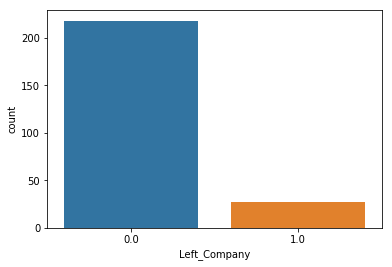

0.0    218
1.0     27
Name: Left_Company, dtype: int64


In [40]:
sns.countplot(x='Left_Company',data=train_merge_empdata)
plt.show()

print(train_merge_empdata.Left_Company.value_counts())

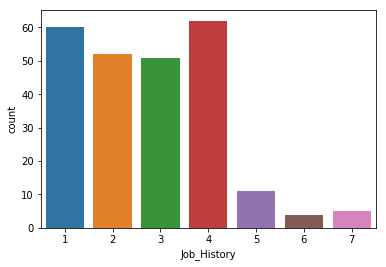

4    62
1    60
2    52
3    51
5    11
7     5
6     4
Name: Job_History, dtype: int64

In [41]:
sns.countplot(x='Job_History',data=train_merge_empdata)
plt.show()
train_merge_empdata.Job_History.value_counts()


In [42]:
train_merge_empdata[train_merge_empdata.Left_Company == 1].Job_History.value_counts(normalize=True)

5    0.407407
4    0.259259
7    0.185185
6    0.148148
3    0.000000
2    0.000000
1    0.000000
Name: Job_History, dtype: float64

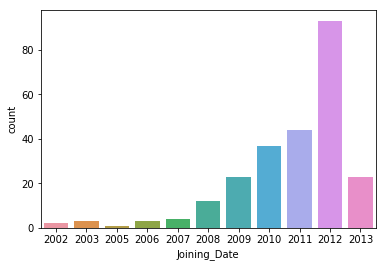

In [43]:
sns.countplot(x='Joining_Date',data=train_merge_empdata)
plt.show()


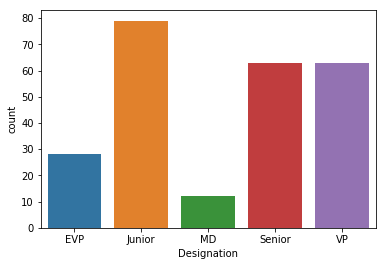

Junior    10
VP         9
Senior     5
MD         2
EVP        1
Name: Designation, dtype: int64

In [44]:
sns.countplot(x='Designation',data=train_merge_empdata)
plt.show()
train_merge_empdata[train_merge_empdata.Left_Company == 1].Designation.value_counts()

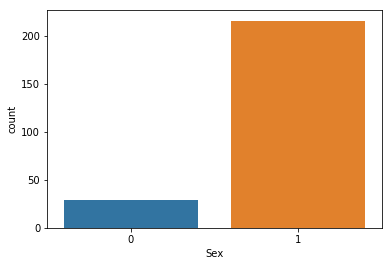

1    22
0     5
Name: Sex, dtype: int64

In [45]:
sns.countplot(x='Sex',data=train_merge_empdata)
plt.show()
train_merge_empdata[train_merge_empdata.Left_Company == 1].Sex.value_counts()

### A heat map is a graphical representation of data where the individual values contained in a matrix are represented as colors.

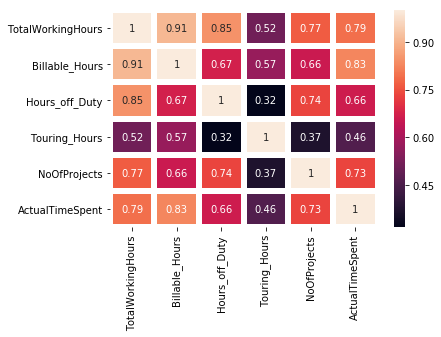

In [46]:
corr = train_merge_empdata.corr()
ax = sns.heatmap(corr,annot =True, linewidth = 5, cbar = True)

#### Histogram is used below for Discrete continous variables for numerical data

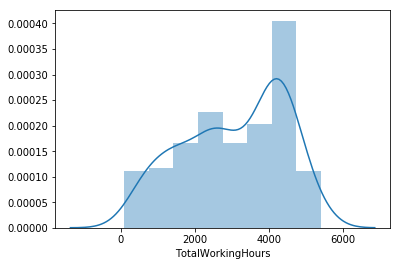

In [47]:
%matplotlib inline
sns.distplot(train_merge_empdata["TotalWorkingHours"])

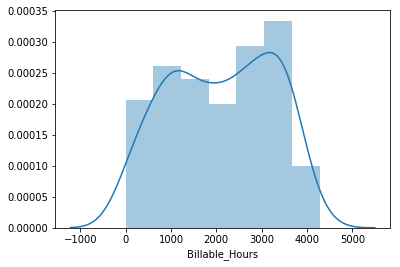

In [48]:
%matplotlib inline
sns.distplot(train_merge_empdata["Billable_Hours"])

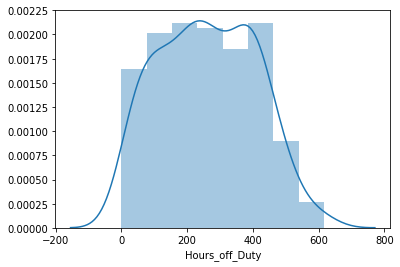

In [49]:
%matplotlib inline
sns.distplot(train_merge_empdata["Hours_off_Duty"])

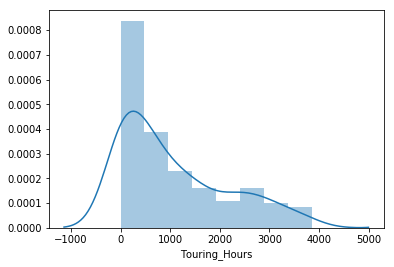

In [50]:
%matplotlib inline
sns.distplot(train_merge_empdata["Touring_Hours"])

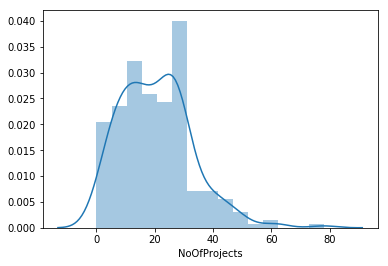

In [51]:
%matplotlib inline
sns.distplot(train_merge_empdata["NoOfProjects"])

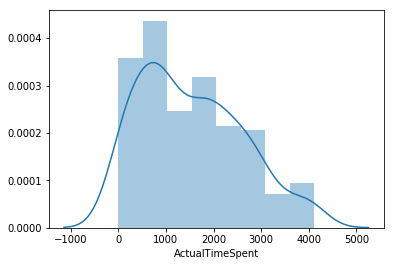

In [52]:
%matplotlib inline
sns.distplot(train_merge_empdata["ActualTimeSpent"])

In [53]:
train_merge_empdata.groupby('Left_Company').mean()

,TotalWorkingHours,Billable_Hours,Hours_off_Duty,Touring_Hours,NoOfProjects,ActualTimeSpent
Left_Company,,,,,,
0.0,3078.671560,2128.448624,257.307339,1062.675688,20.509174,1552.426606
1.0,2922.685185,1847.070370,297.185185,1067.711111,20.518519,1389.888889


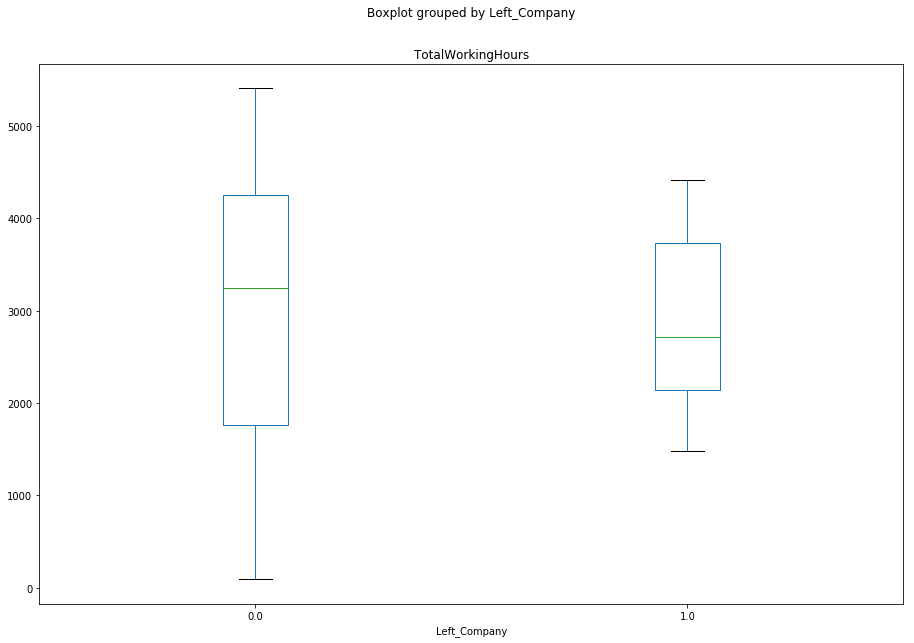

In [54]:
train_merge_empdata.boxplot(by ='Left_Company', column =['TotalWorkingHours'], grid = False, figsize=(15, 10)) 

## Pipeline

In [56]:
train_num_attr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])



train_cat_attr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', train_num_attr, num_attr_train),
        ('cat', train_cat_attr, cat_attr_train)])

## Train validation split

In [57]:
y = train_merge_empdata["Left_Company"]
x = train_merge_empdata.drop(["Left_Company"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 123)

In [58]:
X_train.shape

(171, 11)

In [59]:
X_test.shape

(74, 11)

## Logistic regression

In [60]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression())])

In [61]:
clf_logreg.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [62]:
train_pred = clf_logreg.predict(X_train)
test_pred = clf_logreg.predict(X_test)
print(clf_logreg.score(X_train, y_train))
print(clf_logreg.score(X_test, y_test))

0.9649122807017544
0.9594594594594594


In [65]:
print(confusion_matrix(y_true=y_train, y_pred = train_pred))
confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_pred)
print(confusion_matrix_test)
print("F1 Score:" , f1_score(y_true= y_test, y_pred = test_pred))
print(accuracy_score(y_true= y_test, y_pred = test_pred))

[[152   0]
 [  6  13]]
[[66  0]
 [ 3  5]]
F1 Score: 0.7692307692307693
0.9594594594594594


In [66]:
test_sample_pred = clf_logreg.predict(test_merge_empdata)
test_sample_pred

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])

#### Creating df for saving data in submission file

In [70]:
df = pd.read_csv("test_attrition.csv")

In [78]:
df['EmployeeID']

0     emp-106
1     emp-112
2     emp-114
3     emp-118
4      emp-12
5     emp-121
6     emp-124
7     emp-138
8      emp-14
9     emp-140
10    emp-143
11    emp-147
12     emp-15
13    emp-154
14    emp-155
15    emp-159
16     emp-16
17    emp-164
18    emp-169
19    emp-171
20    emp-172
21    emp-177
22    emp-181
23      emp-2
24     emp-34
25     emp-35
26     emp-37
27     emp-39
28     emp-43
29     emp-44
30     emp-45
31     emp-48
32     emp-54
33     emp-56
34     emp-57
35     emp-63
36     emp-72
37     emp-73
38     emp-75
39     emp-76
40     emp-77
41     emp-78
42     emp-79
43      emp-8
44     emp-83
45     emp-84
46     emp-85
47     emp-86
48     emp-87
49     emp-91
50     emp-95
Name: EmployeeID, dtype: object

In [125]:

new_df = pd.DataFrame(list(zip(df['EmployeeID'],test_sample_pred)),columns=['EmployeeID','Left_Company'])
new_df.to_csv("logistic_reg.csv",index=False)
new_df.shape

(51, 2)

## Decision tree

In [81]:

clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2,10, 20],"classifier__min_samples_leaf": [1, 5, 10]}

dt_grid = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5)

dt_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [82]:
dt_grid.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 8,
 'classifier__min_samples_leaf': 1,
 'classifier__min_samples_split': 20}

In [83]:
train_dt_pred = dt_grid.predict(X_train)
test_dt_pred = dt_grid.predict(X_test)

print(dt_grid.score(X_train, y_train))
print(dt_grid.score(X_test, y_test))


0.9766081871345029
0.9324324324324325


In [84]:
print(confusion_matrix(y_true=y_train, y_pred = train_dt_pred))
confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_dt_pred)
print(confusion_matrix_test)
print("F1 Score:" , f1_score(y_true= y_test, y_pred = test_dt_pred))
print("Recall Score:" , recall_score(y_true= y_test, y_pred = test_dt_pred))
print("Precision Score:" , precision_score(y_true= y_test, y_pred = test_dt_pred))
print(accuracy_score(y_true= y_test, y_pred = test_dt_pred))

[[149   3]
 [  1  18]]
[[62  4]
 [ 1  7]]
F1 Score: 0.7368421052631579
Recall Score: 0.875
Precision Score: 0.6363636363636364
0.9324324324324325


In [85]:
test_sample_pred = dt_grid.predict(test_merge_empdata)
test_sample_pred


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [126]:
new_df = pd.DataFrame(list(zip(df['EmployeeID'],test_sample_pred)),columns=['EmployeeID','Left_Company'])
new_df.to_csv("Decision_tree.csv",index=False)
new_df.shape

(51, 2)

## Random forest

In [88]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])


In [89]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)

rf_param_grid = {"classifier__n_estimators" : [150, 250, 300],
              "classifier__max_depth" : [5,8,10],
              "classifier__max_features" : [3, 5, 7],
              "classifier__min_samples_leaf" : [4, 6, 8, 10]}

rf_grid = GridSearchCV(clf, param_grid=rf_param_grid, cv=kfold)

In [90]:

rf_grid.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=143, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                

In [91]:
train_rf_pred = rf_grid.predict(X_train)
test_rf_pred = rf_grid.predict(X_test)

print(rf_grid.score(X_train, y_train))
print(rf_grid.score(X_test, y_test))

0.9532163742690059
0.918918918918919


In [92]:
print(confusion_matrix(y_true=y_train, y_pred = train_rf_pred))
confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_rf_pred)
print(confusion_matrix_test)
print("F1 Score:" , f1_score(y_true= y_test, y_pred = test_rf_pred))
print(accuracy_score(y_true= y_test, y_pred = test_rf_pred))

[[152   0]
 [  8  11]]
[[66  0]
 [ 6  2]]
F1 Score: 0.4
0.918918918918919


In [93]:
test_sample_pred = rf_grid.predict(test_merge_empdata)
test_sample_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [94]:
test_sample_pred.shape

(51,)

In [95]:
new_df = pd.DataFrame(list(zip(df['EmployeeID'],test_sample_pred)),columns=['EmployeeID','Left_Company'])
new_df.to_csv("Randon_forest.csv",index=False)
new_df.shape

(51, 2)

## KNN_Classifier

In [101]:
from sklearn.neighbors import KNeighborsClassifier

In [102]:
clf_knn = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier(n_neighbors=5))])

In [103]:
clf_knn.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [104]:
train_knn_pred = clf_knn.predict(X_train)
test_knn_pred = clf_knn.predict(X_test)
print(rf_grid.score(X_train, y_train))
print(rf_grid.score(X_test, y_test))

0.9532163742690059
0.918918918918919


In [105]:
print(confusion_matrix(y_true=y_train, y_pred = train_knn_pred))
confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_knn_pred)
print(confusion_matrix_test)
print("F1 Score:" , f1_score(y_true= y_test, y_pred = test_knn_pred))
print("Recall Score:" , recall_score(y_true= y_test, y_pred = test_knn_pred))
print("Precision Score:" , precision_score(y_true= y_test, y_pred = test_knn_pred))
print(accuracy_score(y_true= y_test, y_pred = test_knn_pred))

[[151   1]
 [ 15   4]]
[[66  0]
 [ 7  1]]
F1 Score: 0.2222222222222222
Recall Score: 0.125
Precision Score: 1.0
0.9054054054054054


In [106]:
test_sample_pred = clf_knn.predict(test_merge_empdata)
test_sample_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [107]:
test_sample_pred.shape

(51,)

## SVM Classifier

In [108]:
clf_svm = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])
clf_svm_2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC(kernel='linear', C=1, random_state=0))])


In [109]:
svm_param_grid = { 'C': [0.001, 0.01, 0.1, 1, 10, 100 ],
                'gamma': [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100], 
                'kernel':['linear'] }

svc_grid = GridSearchCV(clf_svm, param_grid = svm_param_grid, cv = 5)

In [111]:
clf_svm_2.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [112]:
train_svc_pred = clf_svm_2.predict(X_train)
test_svc_pred = clf_svm_2.predict(X_test)
print(clf_svm_2.score(X_train, y_train))
print(clf_svm_2.score(X_test, y_test))

0.9707602339181286
0.9864864864864865


In [113]:
print(confusion_matrix(y_true=y_train, y_pred = train_svc_pred))
confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_svc_pred)
print(confusion_matrix_test)
print("F1 Score:" , f1_score(y_true= y_test, y_pred = test_svc_pred))
print("Recall Score:" , recall_score(y_true= y_test, y_pred = test_svc_pred))
print("Precision Score:" , precision_score(y_true= y_test, y_pred = test_svc_pred))
print(accuracy_score(y_true= y_test, y_pred = test_svc_pred))

[[152   0]
 [  5  14]]
[[66  0]
 [ 1  7]]
F1 Score: 0.9333333333333333
Recall Score: 0.875
Precision Score: 1.0
0.9864864864864865


In [114]:
test_sample_pred = clf_svm_2.predict(test_merge_empdata)
test_sample_pred

array([0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0.,
       0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.])

In [116]:
new_df = pd.DataFrame(list(zip(df['EmployeeID'],test_sample_pred)),columns=['EmployeeID','Left_Company'])
new_df.to_csv("SVM_Classifier.csv",index=False)
new_df.shape

(51, 2)

## Gradient Boosting

In [118]:
clf_boost = Pipeline(steps=[('preprocessor', preprocessor),
                      ('GBM',GradientBoostingClassifier())])

In [119]:
gbm_param_grid = {'GBM__max_depth': [8,10,12,14], 'GBM__subsample': [0.8, 0.6], 'GBM__max_features':[0.2, 0.3], 
              'GBM__n_estimators': [10, 20, 30]}

gbm_grid = GridSearchCV(clf_boost, param_grid=gbm_param_grid, cv=3)

gbm_grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [120]:
gbm_grid.best_params_

{'GBM__max_depth': 12,
 'GBM__max_features': 0.3,
 'GBM__n_estimators': 20,
 'GBM__subsample': 0.8}

In [121]:
train_gbm_pred = gbm_grid.predict(X_train)
test_gbm_pred = gbm_grid.predict(X_test)

print(gbm_grid.score(X_train, y_train))
print(gbm_grid.score(X_test, y_test))

1.0
0.9459459459459459


In [122]:
print(confusion_matrix(y_true=y_train, y_pred = train_gbm_pred))
confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_gbm_pred)
print(confusion_matrix_test)
print("F1 Score:" , f1_score(y_true= y_test, y_pred = test_gbm_pred))
print("Recall Score:" , recall_score(y_true= y_test, y_pred = test_gbm_pred))
print("Precision Score:" , precision_score(y_true= y_test, y_pred = test_gbm_pred))
print(accuracy_score(y_true= y_test, y_pred = test_gbm_pred))

[[152   0]
 [  0  19]]
[[66  0]
 [ 4  4]]
F1 Score: 0.6666666666666666
Recall Score: 0.5
Precision Score: 1.0
0.9459459459459459


In [123]:
test_sample_pred = gbm_grid.predict(test_merge_empdata)
test_sample_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [124]:
new_df = pd.DataFrame(list(zip(df['EmployeeID'],test_sample_pred)),columns=['EmployeeID','Left_Company'])
new_df.to_csv("Gradient_Boosting.csv",index=False)
new_df.shape

(51, 2)

## XG Boost

In [128]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgboost',XGBClassifier())])

In [129]:

Xgbm_param_grid = {'xgboost__max_depth': [8,10,12,14], 'xgboost__subsample': [0.8, 0.6,], 'xgboost__max_features':[0.2, 0.3], 
              'xgboost__n_estimators': [10, 20, 30]}

Xgbm_grid = GridSearchCV(clf, param_grid=Xgbm_param_grid, cv=3)


In [130]:
Xgbm_grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                    

In [132]:
Xgbm_grid.best_params_

{'xgboost__max_depth': 8,
 'xgboost__max_features': 0.2,
 'xgboost__n_estimators': 30,
 'xgboost__subsample': 0.8}

In [133]:
train_Xgbm_pred = Xgbm_grid.predict(X_train)
test_Xgbm_pred = Xgbm_grid.predict(X_test)

print(Xgbm_grid.score(X_train, y_train))
print(Xgbm_grid.score(X_test, y_test))

0.9707602339181286
0.9594594594594594


In [134]:
print(confusion_matrix(y_true=y_train, y_pred = train_Xgbm_pred))
confusion_matrix_test = confusion_matrix(y_true=y_test, y_pred =  test_Xgbm_pred)
print(confusion_matrix_test)
print("F1 Score:" , f1_score(y_true= y_test, y_pred = test_Xgbm_pred))
print("Recall Score:" , recall_score(y_true= y_test, y_pred = test_Xgbm_pred))
print("Precision Score:" , precision_score(y_true= y_test, y_pred = test_Xgbm_pred))
print(accuracy_score(y_true= y_test, y_pred = test_Xgbm_pred))

[[152   0]
 [  5  14]]
[[66  0]
 [ 3  5]]
F1 Score: 0.7692307692307693
Recall Score: 0.625
Precision Score: 1.0
0.9594594594594594


In [135]:
test_sample_pred = Xgbm_grid.predict(test_merge_empdata)
test_sample_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [136]:
new_df = pd.DataFrame(list(zip(df['EmployeeID'],test_sample_pred)),columns=['EmployeeID','Left_Company'])
new_df.to_csv("XG_Boosting.csv",index=False)
new_df.shape

(51, 2)

## Final conclusion

#### Differnt algorithims gives different output based on preprocessing steps it varies the output.so, Xb boost ,Logistic and decision tree got high F1 scores.I came to conclusion that xb boost or decision tree suitable for employee attrition model.